##Edgard Henrique Coelho Tavares da Silva - 20210027041
##Gustavo Henrique de Carvalho Costa Filho - 20210027060

#Questão 2

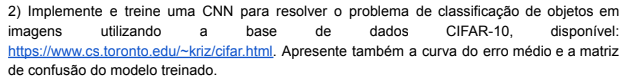

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
import pickle
import torch.nn.functional as F

In [ ]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10_data(batch_files):
    train_data = []
    train_labels = []

    # Processing training batches
    for i in range(5):
        data_dict = unpickle(batch_files[i])
        if i == 0:
            train_data = data_dict[b'data']
            train_labels = data_dict[b'labels']
        else:
            train_data = np.vstack((train_data, data_dict[b'data']))
            train_labels += data_dict[b'labels']

    # Processing test batch
    test_data_dict = unpickle(batch_files[5])
    test_data = test_data_dict[b'data']
    test_labels = test_data_dict[b'labels']

    return train_data, train_labels, test_data, test_labels

# File paths provided here are just a placeholder
batch_files = [
    'data_batch_1',
    'data_batch_2',
    'data_batch_3',
    'data_batch_4',
    'data_batch_5',
    'test_batch'
]

In [ ]:
train_images, train_targets, test_images, test_targets = load_cifar10_data(batch_files)

In [ ]:
label_names = ['plane', 'auto', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
label_dict = {i: name for i, name in enumerate(label_names)}
print(label_dict)

{0: 'plane', 1: 'auto', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 3, 32, 32)
train_images = train_images.transpose(0, 2, 3, 1)
test_images = test_images.reshape(test_images.shape[0], 3, 32, 32)
test_images = test_images.transpose(0, 2, 3, 1)

In [ ]:
train_targets = np.array(train_targets)
test_targets = np.array(test_targets)

In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [ ]:
train_images_tensor = torch.tensor(train_images, dtype=torch.float32).permute(0, 3, 1, 2)
train_targets_tensor = torch.tensor(train_targets, dtype=torch.long)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32).permute(0, 3, 1, 2)
test_targets_tensor = torch.tensor(test_targets, dtype=torch.long)

In [ ]:
batch_size = 64
train_set = TensorDataset(train_images_tensor, train_targets_tensor)
test_set = TensorDataset(test_images_tensor, test_targets_tensor)
train_data_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class CNN_2(nn.Module):
    def __init__(self):
        super(CNN_2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(128 * 8 * 8, 1024)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout2(x)

        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x


In [ ]:
model = CNN_2().to(device)
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
epoch_train_losses = []
epoch_train_accuracies = []
epoch_test_losses = []
epoch_test_accuracies = []
num_epochs = 20

In [ ]:
for epoch_idx in range(num_epochs):
    # Modo de treinamento
    model.train()
    correct_train_preds = 0
    total_train_samples = 0

    for batch_inputs, batch_targets in train_data_loader:
        # Mover dados para GPU
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

        optimizer.zero_grad()
        model_outputs = model(batch_inputs)
        batch_loss = criterion(model_outputs, batch_targets)

        batch_loss.backward()
        optimizer.step()

        _, batch_predictions = torch.max(model_outputs, 1)
        total_train_samples += batch_targets.size(0)
        correct_train_preds += (batch_predictions == batch_targets).sum().item()

    avg_train_loss = batch_loss.item() / len(train_data_loader)
    train_accuracy = correct_train_preds / total_train_samples
    epoch_train_losses.append(avg_train_loss)
    epoch_train_accuracies.append(train_accuracy)

    # Modo de validação
    model.eval()
    correct_test_preds = 0
    total_test_samples = 0
    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for batch_inputs_test, batch_targets_test in test_data_loader:
            batch_inputs_test, batch_targets_test = batch_inputs_test.to(device), batch_targets_test.to(device)

            model_outputs_test = model(batch_inputs_test)
            batch_loss_test = criterion(model_outputs_test, batch_targets_test)

            _, batch_predictions_test = torch.max(model_outputs_test, 1)
            total_test_samples += batch_targets_test.size(0)
            correct_test_preds += (batch_predictions_test == batch_targets_test).sum().item()

            # Armazenar rótulos e previsões
            all_true_labels.extend(batch_targets_test.cpu().numpy())  # Mover para CPU antes de converter para numpy
            all_predicted_labels.extend(batch_predictions_test.cpu().numpy())  # Mover para CPU antes de converter para numpy

        avg_test_loss = batch_loss_test.item() / len(test_data_loader)
        test_accuracy = correct_test_preds / total_test_samples
        epoch_test_losses.append(avg_test_loss)
        epoch_test_accuracies.append(test_accuracy)

    # Exibir resultados por época
    print(f"Epoch [{epoch_idx+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch [1/20], Train Loss: 0.0016, Train Accuracy: 0.4099, Test Loss: 0.0071, Test Accuracy: 0.5843
Epoch [2/20], Train Loss: 0.0015, Train Accuracy: 0.6180, Test Loss: 0.0060, Test Accuracy: 0.6749
Epoch [3/20], Train Loss: 0.0010, Train Accuracy: 0.7008, Test Loss: 0.0047, Test Accuracy: 0.7280
Epoch [4/20], Train Loss: 0.0010, Train Accuracy: 0.7460, Test Loss: 0.0046, Test Accuracy: 0.7405
Epoch [5/20], Train Loss: 0.0009, Train Accuracy: 0.7790, Test Loss: 0.0053, Test Accuracy: 0.7757
Epoch [6/20], Train Loss: 0.0005, Train Accuracy: 0.8034, Test Loss: 0.0059, Test Accuracy: 0.7705
Epoch [7/20], Train Loss: 0.0005, Train Accuracy: 0.8270, Test Loss: 0.0047, Test Accuracy: 0.7914
Epoch [8/20], Train Loss: 0.0006, Train Accuracy: 0.8432, Test Loss: 0.0058, Test Accuracy: 0.7934
Epoch [9/20], Train Loss: 0.0008, Train Accuracy: 0.8594, Test Loss: 0.0066, Test Accuracy: 0.7924
Epoch [10/20], Train Loss: 0.0010, Train Accuracy: 0.8696, Test Loss: 0.0030, Test Accuracy: 0.7912
Epoch [11

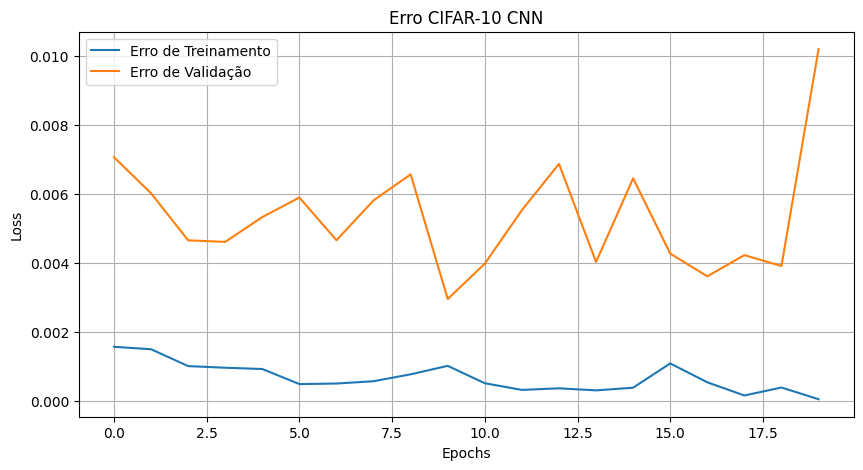

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), epoch_train_losses, label='Erro de Treinamento')
plt.plot(range(num_epochs), epoch_test_losses, label='Erro de Validação')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Erro CIFAR-10 CNN')
plt.legend()
plt.grid(True)
plt.show()

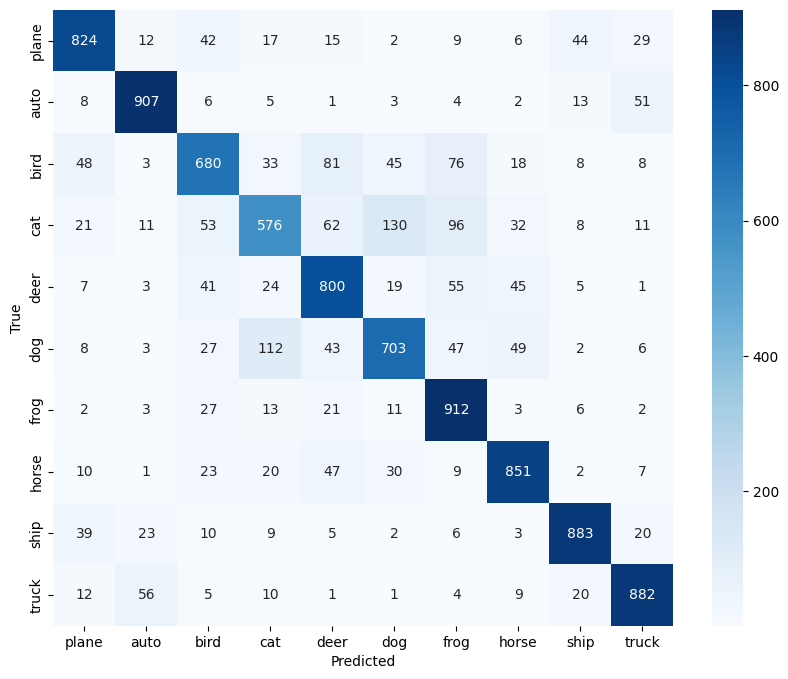

10000


In [ ]:
plt.figure(figsize=(10, 8))
confusion = confusion_matrix(all_true_labels, all_predicted_labels)
heatmap = sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
heatmap.set_xticklabels(label_dict.values())
heatmap.set_yticklabels(label_dict.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
print(len(all_true_labels))


#Questão 3


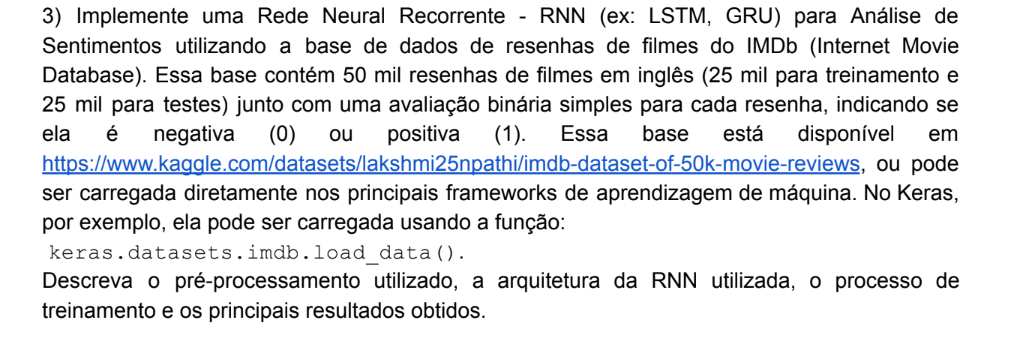

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nltk

In [ ]:
df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df.isnull().sum()

,0
review,0
sentiment,0


In [ ]:
df["review"][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stopwords_list = set(stopwords.words('english'))


Tag_re = re.compile(r'<[^>]+>')

def r_tags(text):
    return Tag_re.sub('', text)


class Preprocess():
    def __init__(self):
        pass

    def preprocess_text(self,txt):
        txt = txt.lower()

        # Remove tags html
        texto = r_tags(txt)

        # Remove pontuaçao e numero
        texto = re.sub('[^a-zA-Z]', ' ', texto)

        # caracteres unicos
        texto = re.sub(r"\s+[a-zA-Z]\s+", ' ', texto)

        # Remove espaços
        texto = re.sub(r'\s+', ' ', texto)

        # Remove Stopwords
        #pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
        #texto = pattern.sub('', texto)

        return texto

In [ ]:
# Criar uma instância da classe
pre = Preprocess()
x = []
texto = list(df['review'])
for txt in texto:
    x.append(pre.preprocess_text(txt))

In [ ]:
y = df['sentiment']
sentiment_map = {'negative' : 0, 'positive': 1}
y = np.array(y.map(sentiment_map))
y[:15]

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1])

In [ ]:
max_words = 20000

# Tokenização
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)

max_sequence_length = 200
X = pad_sequences(sequences, maxlen=max_sequence_length)

print(f"Tamanho da matriz de entrada: {X.shape}")

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Tamanho do conjunto de treino: {x_train.shape}")
print(f"Tamanho do conjunto de teste: {x_test.shape}")


Tamanho da matriz de entrada: (50000, 200)
Tamanho do conjunto de treino: (35000, 200)
Tamanho do conjunto de teste: (15000, 200)


In [ ]:
vocab_size = 20000
embedding_dim = 128
max_sequence_length = 200

model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

model.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history =  model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

test_loss, test_accuracy =  model.evaluate(x_test, y_test)
print(f"Acurácia no conjunto de teste: {test_accuracy:.4f}")
train_loss, train_accuracy =  model.evaluate(x_train, y_train)
print(f"Acurácia no conjunto de treino: {train_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_28 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_22 (Activation)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_55 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_26 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_23 (Activation)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6158 - loss: 0.7565 - val_accuracy: 0.8231 - val_loss: 0.4748
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.8327 - loss: 0.4344 - val_accuracy: 0.8117 - val_loss: 0.4407
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.8556 - loss: 0.3893 - val_accuracy: 0.8527 - val_loss: 0.3870
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9240 - loss: 0.2594 - val_accuracy: 0.8570 - val_loss: 0.3767
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9472 - loss: 0.1958 - val_accuracy: 0.8384 - val_loss: 0.4386
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9637 - loss: 0.1512 - val_accuracy: 0.8479 - val_loss: 0.4838
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8583 - loss: 0.3712
Acurácia no conjunto de teste: 0.8617
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9529 - loss: 0.2036
Acurácia no conjunto de treino

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step


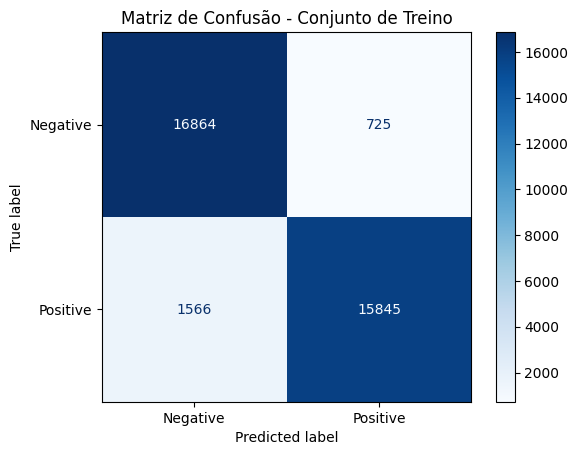

469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


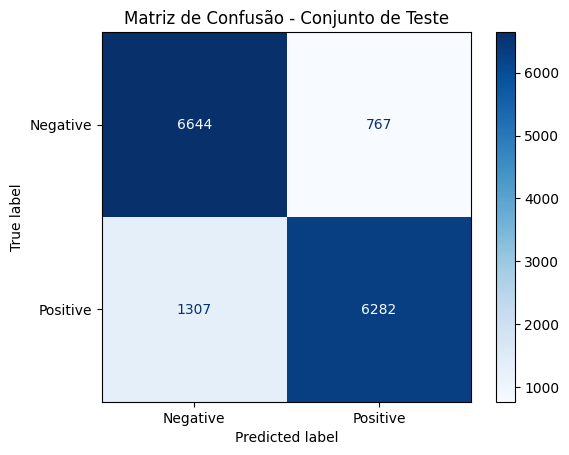

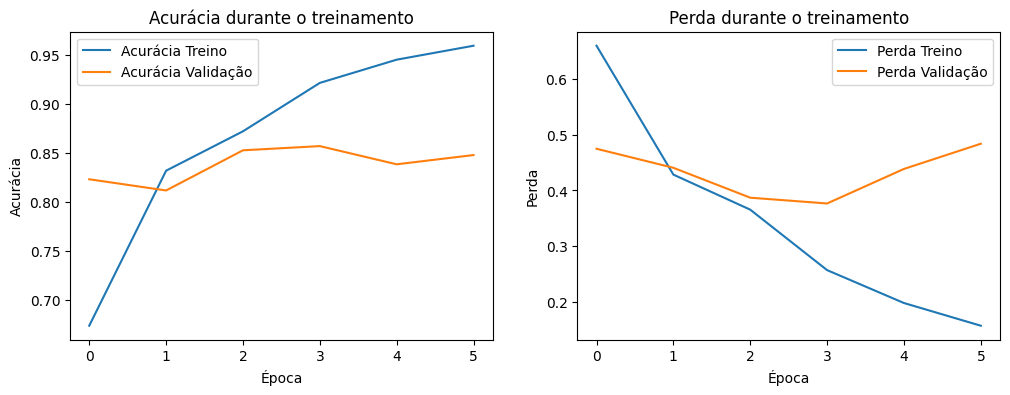

In [ ]:
y_train_pred = model.predict(x_train)
y_train_pred_classes = np.where(y_train_pred > 0.5, 1, 0)

cm_train = confusion_matrix(y_train, y_train_pred_classes)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Negative', 'Positive'])
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Conjunto de Treino")
plt.show()

y_test_pred = model.predict(x_test)
y_test_pred_classes = np.where(y_test_pred > 0.5, 1, 0)

cm_test = confusion_matrix(y_test, y_test_pred_classes)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive'])
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Conjunto de Teste")
plt.show()

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia Treino')
    plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
    plt.title('Acurácia durante o treinamento')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    # Perda
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda Treino')
    plt.plot(history.history['val_loss'], label='Perda Validação')
    plt.title('Perda durante o treinamento')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()

    plt.show()

plot_training_history(history)


In [ ]:
model_tanh = Sequential()
model_tanh.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

model_tanh.add(LSTM(128, return_sequences=True,activation='tanh', kernel_regularizer=l2(0.001)))
model_tanh.add(Dropout(0.3))

model_tanh.add(LSTM(64, return_sequences=False, activation='tanh', kernel_regularizer=l2(0.001)))
model_tanh.add(Dropout(0.3))

model_tanh.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

model_tanh.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_tanh.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history =  model_tanh.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

test_loss, test_accuracy =  model_tanh.evaluate(x_test, y_test)
print(f"Acurácia no conjunto de teste: {test_accuracy:.4f}")
train_loss, train_accuracy =  model_tanh.evaluate(x_train, y_train)
print(f"Acurácia no conjunto de treino: {train_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_29 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_28 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.7274 - loss: 0.6510 - val_accuracy: 0.8429 - val_loss: 0.4146
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.8846 - loss: 0.3328 - val_accuracy: 0.8506 - val_loss: 0.3577
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9302 - loss: 0.2118 - val_accuracy: 0.8650 - val_loss: 0.3323
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9487 - loss: 0.1677 - val_accuracy: 0.8623 - val_loss: 0.4406
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9606 - loss: 0.1357 - val_accuracy: 0.8610 - val_loss: 0.4200
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8676 - loss: 0.3239
Acurácia no conjunto de teste: 0.8692
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9565 - loss: 0.1672
Acurácia no conjunto de treino: 0.9398


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step


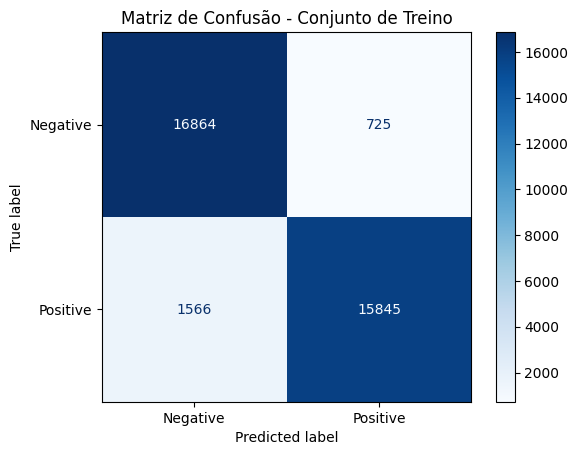

469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


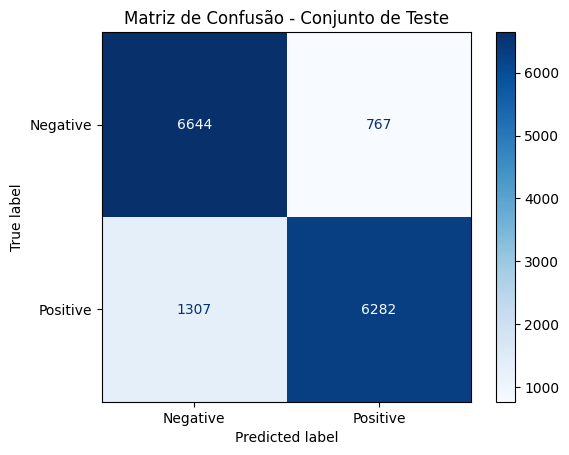

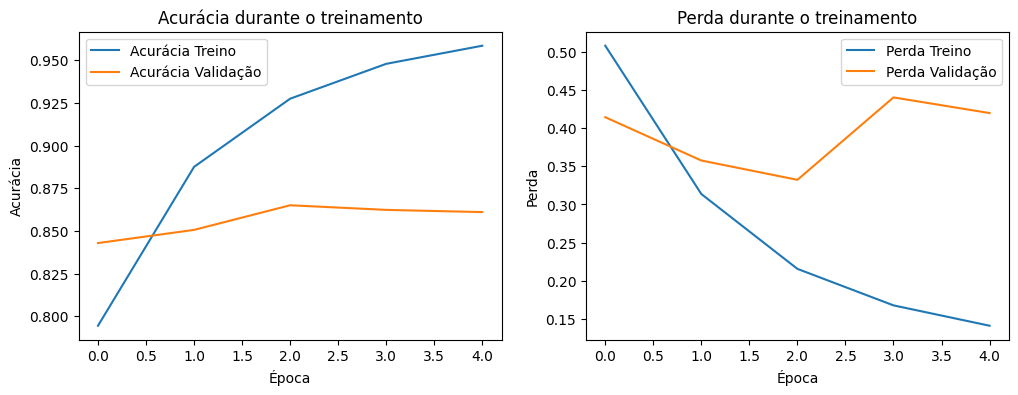

In [ ]:
y_train_pred = model.predict(x_train)
y_train_pred_classes = np.where(y_train_pred > 0.5, 1, 0)

cm_train = confusion_matrix(y_train, y_train_pred_classes)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Negative', 'Positive'])
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Conjunto de Treino")
plt.show()

y_test_pred = model.predict(x_test)
y_test_pred_classes = np.where(y_test_pred > 0.5, 1, 0)

cm_test = confusion_matrix(y_test, y_test_pred_classes)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive'])
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Conjunto de Teste")
plt.show()

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia Treino')
    plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
    plt.title('Acurácia durante o treinamento')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda Treino')
    plt.plot(history.history['val_loss'], label='Perda Validação')
    plt.title('Perda durante o treinamento')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()

    plt.show()

plot_training_history(history)


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_35 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_41 (GRU)                         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_30 (Activation)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_69 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_42 (GRU)                         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_31 (Activation)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_70 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.6503 - loss: 0.6917 - val_accuracy: 0.8344 - val_loss: 0.3944
Epoch 2/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8915 - loss: 0.3102 - val_accuracy: 0.8783 - val_loss: 0.3110
Epoch 3/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9317 - loss: 0.2169 - val_accuracy: 0.8787 - val_loss: 0.3060
Epoch 4/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9547 - loss: 0.1565 - val_accuracy: 0.8849 - val_loss: 0.3435
Epoch 5/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9730 - loss: 0.1094 - val_accuracy: 0.8799 - val_loss: 0.3975
Epoch 6/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9816 - loss: 0.0865 - val_accuracy: 0.8764 - val_loss: 0.4620
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8779 - loss: 0.3048
Acurácia no conjunto de teste com GRU: 0.8795


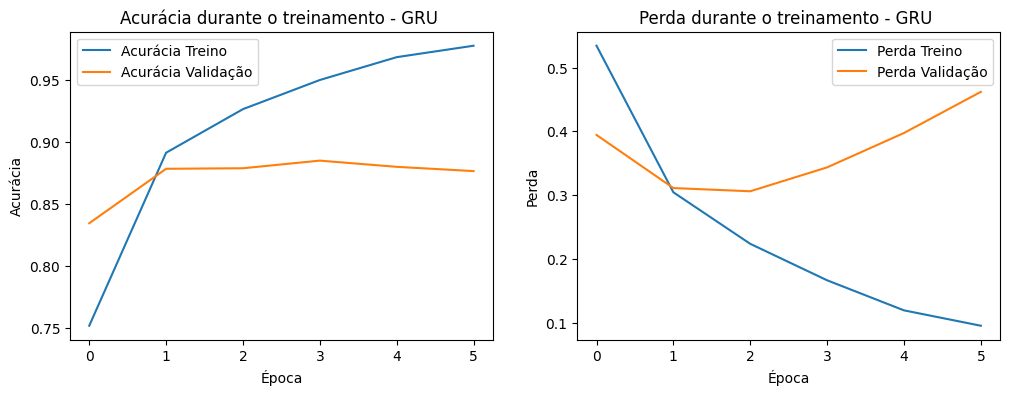

In [ ]:
model_gru = Sequential()

model_gru.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

model_gru.add(GRU(128, return_sequences=True, kernel_regularizer=l2(0.001)))
model_gru.add(Activation('relu'))
model_gru.add(Dropout(0.5))

model_gru.add(GRU(64, return_sequences=False, kernel_regularizer=l2(0.001)))

model_gru.add(Activation('relu'))
model_gru.add(Dropout(0.5))

model_gru.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_gru.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_gru = model_gru.fit(x_train, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

test_loss_gru, test_accuracy_gru = model_gru.evaluate(x_test, y_test)
print(f"Acurácia no conjunto de teste com GRU: {test_accuracy_gru:.4f}")

def plot_training_history(history, title='Desempenho durante o treinamento'):
    plt.figure(figsize=(12, 4))

    # Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia Treino')
    plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
    plt.title(f'Acurácia durante o treinamento - {title}')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    # Perda
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda Treino')
    plt.plot(history.history['val_loss'], label='Perda Validação')
    plt.title(f'Perda durante o treinamento - {title}')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()

    plt.show()

plot_training_history(history_gru, title='GRU ')


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_32 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_35 (GRU)                         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_63 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_36 (GRU)                         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_64 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.7047 - loss: 0.6382 - val_accuracy: 0.8556 - val_loss: 0.3623
Epoch 2/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9063 - loss: 0.2632 - val_accuracy: 0.8774 - val_loss: 0.3149
Epoch 3/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9429 - loss: 0.1748 - val_accuracy: 0.8860 - val_loss: 0.3144
Epoch 4/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9655 - loss: 0.1214 - val_accuracy: 0.8746 - val_loss: 0.3963
Epoch 5/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9728 - loss: 0.1002 - val_accuracy: 0.8753 - val_loss: 0.3857
Epoch 6/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9793 - loss: 0.0797 - val_accuracy: 0.8719 - val_loss: 0.4866
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8831 - loss: 0.3097
Acurácia no conjunto de teste com GRU e ativação tanh: 0.8827


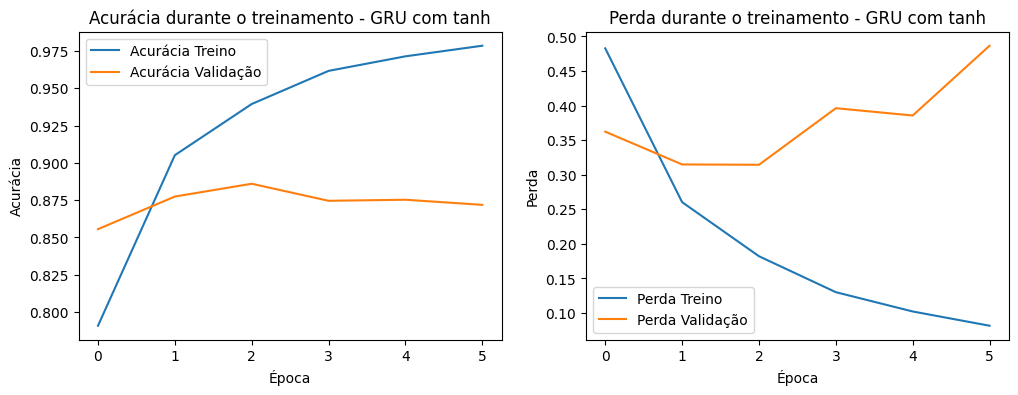

In [ ]:
model_gru_tanh = Sequential()

model_gru_tanh.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

model_gru_tanh.add(GRU(128, return_sequences=True, activation='tanh', kernel_regularizer=l2(0.001)))
model_gru_tanh.add(Dropout(0.3))

model_gru_tanh.add(GRU(64, return_sequences=False, activation='tanh', kernel_regularizer=l2(0.001)))
model_gru_tanh.add(Dropout(0.3))

model_gru_tanh.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

model_gru_tanh.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_gru_tanh.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_gru_tanh = model_gru_tanh.fit(x_train, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

test_loss_gru_tanh, test_accuracy_gru_tanh = model_gru_tanh.evaluate(x_test, y_test)
print(f"Acurácia no conjunto de teste com GRU e ativação tanh: {test_accuracy_gru_tanh:.4f}")

def plot_training_history(history, title='Desempenho durante o treinamento'):
    plt.figure(figsize=(12, 4))

    # Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia Treino')
    plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
    plt.title(f'Acurácia durante o treinamento - {title}')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    # Perda
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda Treino')
    plt.plot(history.history['val_loss'], label='Perda Validação')
    plt.title(f'Perda durante o treinamento - {title}')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()

    plt.show()

plot_training_history(history_gru_tanh, title='GRU com tanh')
